In [9]:
# Import需要的套件
import os
import numpy as np
import cv2
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import time
import os
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import os

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [18]:
# Import需要的套件
import os
import numpy as np
import cv2
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import time
import os
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
# 定义标签和类别字典以及常量 N
label_dict = {"dandelion": 0, "rose": 1, "daisy": 2}
class_dict = {0: "dandelion", 1: "rose", 2: "daisy"}
N = 3  # 总共三个类别

class MyDataset(Dataset):
    def __init__(self, _data_dir, _transform, _loader):
        # 获取标签文件夹列表
        self.labels = [_label for _label in os.listdir(_data_dir)]
        _file_path_label_list = [(os.path.join(_data_dir, _label, _img_fn), _label)
                                 for _label in os.listdir(_data_dir)
                                 for _img_fn in os.listdir(os.path.join(_data_dir, _label))
                                 if not os.path.isdir(os.path.join(_data_dir, _label, _img_fn))]

        self.data = [(_loader(_fp), label_dict[_label]) for _fp, _label in _file_path_label_list]
        self.transform = _transform
#         self.labels = [label for label in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, label))]
        
#         # 获取图像路径和标签的配对列表
#         self.data = []
#         for label in self.labels:
#             label_path = os.path.join(data_dir, label)
#             for img_fn in os.listdir(label_path):
#                 img_path = os.path.join(label_path, img_fn)
#                 if not os.path.isdir(img_path):
#                     self.data.append((img_path, label_dict[label]))

        # self.transform = transform

    def __getitem__(self, item):
        _img, _label = self.data[item]
        _img = self.transform(_img)
        return _img, _label
        # img_path, label = self.data[index]
        # img = Image.open(img_path).convert('RGB')
        # if self.transform:
        #     img = self.transform(img)
        # return img, label

    def __len__(self):
        return len(self.data)

def load_data():
    print('data processing...')
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.3),
        transforms.RandomVerticalFlip(p=0.3),
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))  # normalization
    ])
    data_dir = "data/training_data/"
    train_dataset = MyDataset(data_dir, transform, _loader=lambda _path: Image.open(_path).convert('RGB'))
    test_dataset = MyDataset(data_dir, transform, _loader=lambda _path: Image.open(_path).convert('RGB'))

    train_size = int(len(train_dataset) * 0.8)
    validate_size = len(train_dataset) - train_size
    train, val = torch.utils.data.random_split(train_dataset, [train_size, validate_size])

    train_data_loader = DataLoader(dataset=train, batch_size=50, shuffle=True, num_workers=0)
    val_data_loader = DataLoader(dataset=val, batch_size=50, shuffle=True, num_workers=0)
    test_data_loader = DataLoader(dataset=test_dataset, batch_size=50, shuffle=False, num_workers=0)

    return train_data_loader, val_data_loader, test_data_loader

In [19]:
import copy
import os
import random

import numpy as np
import torch
import torch.nn as nn
from torch import optim
from tqdm import tqdm

# from classify.data_process import load_data, N, label_dict, class_dict
import torch.nn.functional as F

from classify.decorator import metric_time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def setup_seed(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True


setup_seed(20)


class cnn(nn.Module):
    def __init__(self, in_channels=3):
        super(cnn, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=16,
                kernel_size=3,
                stride=2,
            ),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=3,
                stride=2,
            ),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=3,
                stride=2,
            ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.fc1 = nn.Linear(3 * 3 * 64, 64)
        self.fc2 = nn.Linear(64, 10)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.out = nn.Linear(10, N)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.shape[0], -1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.out(x))
        x = F.log_softmax(x, dim=1)
        return x


def get_val_loss(model, Val):
    model.eval()
    criterion = nn.CrossEntropyLoss().to(device)
    val_loss = []
    for (data, target) in Val:
        data, target = data.to(device), target.long().to(device)
        output = model(data)
        loss = criterion(output, target)
        val_loss.append(loss.cpu().item())

    return np.mean(val_loss)


@metric_time
def train():
    train_data_loader, val_data_loader, _ = load_data()
    print('train...')
    epoch_num = 30
    best_model = None
    min_epochs = 5
    min_val_loss = 5
    model = cnn().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.0008)
    criterion = nn.CrossEntropyLoss().to(device)
    for epoch in tqdm(range(epoch_num), ascii=True):
        train_loss = []
        for batch_idx, (data, target) in enumerate(train_data_loader):
            data, target = data.to(device), target.long().to(device)
            model.train()
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.cpu().item())
        # validation
        val_loss = get_val_loss(model, val_data_loader)
        if epoch + 1 > min_epochs and val_loss < min_val_loss:
            min_val_loss = val_loss
            best_model = copy.deepcopy(model)

        tqdm.write('Epoch {:03d} train_loss {:.5f} val_loss {:.5f}'.format(epoch, np.mean(train_loss), val_loss))

    torch.save(best_model.state_dict(), "model/cnn.pkl")


@metric_time
def test():
    _, _, test_dataset = load_data()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = cnn().to(device)
    model.load_state_dict(torch.load("model/cnn.pkl"), False)
    total = 0
    current = 0
    model.eval()
    for (data, target) in test_dataset:
        data, target = data.to(device), target.to(device)
        outputs = model(data)
        predicted = torch.max(outputs.data, 1)[1].data
        total += target.size(0)
        current += (predicted == target).sum()

    print('Accuracy:%d%%' % (100 * current / total))

# 训练模型

In [20]:
train()

data processing...
train...


  3%|##7                                                                                | 1/30 [00:00<00:26,  1.08it/s]

Epoch 000 train_loss 1.11540 val_loss 1.10034


  7%|#####5                                                                             | 2/30 [00:01<00:25,  1.09it/s]

Epoch 001 train_loss 1.06290 val_loss 1.09440


 10%|########3                                                                          | 3/30 [00:02<00:24,  1.10it/s]

Epoch 002 train_loss 1.04587 val_loss 1.08361


 13%|###########                                                                        | 4/30 [00:03<00:23,  1.11it/s]

Epoch 003 train_loss 1.00304 val_loss 1.06453


 17%|#############8                                                                     | 5/30 [00:04<00:22,  1.10it/s]

Epoch 004 train_loss 1.05207 val_loss 1.03495


 20%|################6                                                                  | 6/30 [00:05<00:21,  1.10it/s]

Epoch 005 train_loss 0.98051 val_loss 1.00999


 23%|###################3                                                               | 7/30 [00:06<00:20,  1.12it/s]

Epoch 006 train_loss 1.00924 val_loss 0.97938


 27%|######################1                                                            | 8/30 [00:07<00:19,  1.11it/s]

Epoch 007 train_loss 0.90080 val_loss 0.96939


 30%|########################9                                                          | 9/30 [00:08<00:19,  1.10it/s]

Epoch 008 train_loss 0.98210 val_loss 0.92270


 33%|###########################3                                                      | 10/30 [00:09<00:18,  1.10it/s]

Epoch 009 train_loss 0.94979 val_loss 0.89149


 37%|##############################                                                    | 11/30 [00:10<00:17,  1.08it/s]

Epoch 010 train_loss 1.01173 val_loss 0.88988


 40%|################################8                                                 | 12/30 [00:10<00:16,  1.08it/s]

Epoch 011 train_loss 0.87574 val_loss 0.88454


 43%|###################################5                                              | 13/30 [00:11<00:15,  1.11it/s]

Epoch 012 train_loss 0.90287 val_loss 0.89160


 47%|######################################2                                           | 14/30 [00:12<00:14,  1.12it/s]

Epoch 013 train_loss 0.82723 val_loss 0.85359


 50%|#########################################                                         | 15/30 [00:13<00:13,  1.11it/s]

Epoch 014 train_loss 0.90750 val_loss 0.83655


 53%|###########################################7                                      | 16/30 [00:14<00:12,  1.10it/s]

Epoch 015 train_loss 0.89057 val_loss 0.79147


 57%|##############################################4                                   | 17/30 [00:15<00:11,  1.09it/s]

Epoch 016 train_loss 0.89474 val_loss 0.78788


 60%|#################################################1                                | 18/30 [00:16<00:10,  1.09it/s]

Epoch 017 train_loss 0.85770 val_loss 0.79990


 63%|###################################################9                              | 19/30 [00:17<00:10,  1.09it/s]

Epoch 018 train_loss 0.78765 val_loss 0.80095


 67%|######################################################6                           | 20/30 [00:18<00:09,  1.09it/s]

Epoch 019 train_loss 0.76481 val_loss 0.78276


 70%|#########################################################4                        | 21/30 [00:19<00:08,  1.09it/s]

Epoch 020 train_loss 0.79566 val_loss 0.76540


 73%|############################################################1                     | 22/30 [00:20<00:07,  1.10it/s]

Epoch 021 train_loss 0.81083 val_loss 0.73966


 77%|##############################################################8                   | 23/30 [00:20<00:06,  1.10it/s]

Epoch 022 train_loss 0.84684 val_loss 0.74669


 80%|#################################################################6                | 24/30 [00:21<00:05,  1.09it/s]

Epoch 023 train_loss 0.74590 val_loss 0.78378


 83%|####################################################################3             | 25/30 [00:22<00:04,  1.09it/s]

Epoch 024 train_loss 0.76372 val_loss 0.79440


 87%|#######################################################################           | 26/30 [00:23<00:03,  1.08it/s]

Epoch 025 train_loss 0.84068 val_loss 0.73856


 90%|#########################################################################8        | 27/30 [00:24<00:02,  1.09it/s]

Epoch 026 train_loss 0.70287 val_loss 0.72761


 93%|############################################################################5     | 28/30 [00:25<00:01,  1.09it/s]

Epoch 027 train_loss 0.84485 val_loss 0.72091


 97%|###############################################################################2  | 29/30 [00:26<00:00,  1.09it/s]

Epoch 028 train_loss 0.81201 val_loss 0.72305


100%|##################################################################################| 30/30 [00:27<00:00,  1.10it/s]
2024-11-28 17:14:31.569 | DEBUG    | classify.decorator:wrapper:13 - train运行时间: 28.829385995864868 s


Epoch 029 train_loss 0.69325 val_loss 0.76869


# 测试模型预测准确率

In [21]:
test()

data processing...


C:\Users\admin\AppData\Local\Temp/ipykernel_6396/934605258.py:138: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model/cnn.pkl"), False)
20

Accuracy:85%


In [14]:
from PIL import Image
from matplotlib import pyplot as plt
from torchvision import transforms

In [22]:
model = cnn().to(device)
model.load_state_dict(torch.load("model/cnn.pkl"), False)
model.eval()

_img_path = "data/testing_data/rose/229488796_21ac6ee16d_n.jpg"

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))  # normalization
])
img = Image.open(_img_path).convert('RGB')
# 模拟批样本
img_transform = transform(img).unsqueeze(0)

output = model(img_transform)
pred = class_dict[torch.max(output.data, 1)[1].data.item()]
print(pred)

rose


C:\Users\admin\AppData\Local\Temp/ipykernel_6396/2328750990.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model/cnn.pkl"), False)


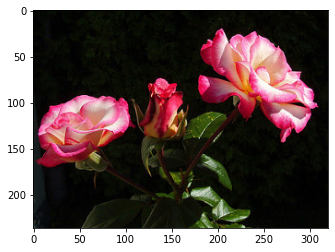

In [23]:
plt.imshow(img, cmap='gray')
plt.show()